# JPMorgan & Chase Co. - Quant Researcher Experience
## Task 3: Credit risk analysis

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Read file to see what data we are working with
Loans = pd.read_csv('/Users/Sajeeth/Documents/Quant Experience/Task 3/Task 3 and 4_Loan_Data.csv')
Loans

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [3]:
# Check to see if there is any missing data in our dataframe that will affect our predicting models
Loans.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

In [4]:
# Now we will quickly check our data for any extreme and obvious outliers (except customer_id since these are insignificant numbers)
round(Loans.drop(['customer_id'], axis=1, inplace=False).describe())

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,1.0,4160.0,8719.0,70040.0,5.0,638.0,0.0
std,2.0,1421.0,6627.0,20072.0,2.0,61.0,0.0
min,0.0,47.0,32.0,1000.0,0.0,408.0,0.0
25%,0.0,3154.0,4200.0,56540.0,3.0,597.0,0.0
50%,1.0,4052.0,6732.0,70086.0,5.0,638.0,0.0
75%,2.0,5053.0,11272.0,83429.0,6.0,679.0,0.0
max,5.0,10751.0,43689.0,148412.0,10.0,850.0,1.0


## Logisitic regression
We use logistic regression since our default is binary - where it is either 0 or 1 (loanee does not default or loanee does default)

In [5]:
# Firstly we will set our X and y
# X will have all columns except customer_id and default since the probability of defaulting is independent of customer id and default column will be our y
X = Loans.drop(['customer_id','default'], axis=1, inplace=False)
y = Loans['default']

# Now we split our dataset into test data and train data with the test size being 25% (2500 rows) and we include a fixed random_state for reproducibility of results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
#print(X_test.shape, X_train.shape)
#print(X_test)
#print(X_train)

In [6]:
# For later in order to avoid writing all columns out
cols = X_train.columns

In [7]:
# Note how our values in our dataframe vary from ranging from 0 to 5 in the case of credit lines outstanding but 1000 to ~148000 in the case of income
# In order to get an accurate regression model, we must scale our data which ensures that all features contribute equally to the model's calculations
# This prevents features with larger ranges from dominating the learning process, which can significantly improve the model's performance
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# To read and access our data easier, we will put our train and test data into a pandas dataframe
X_test = pd.DataFrame(X_test, columns=[cols])
X_train = pd.DataFrame(X_train, columns=[cols])

#display(X_test)
#display(X_train)
#display(X_test.describe())
display(X_train.describe())

# Looking at the data below, it is clear that our scaling has worked since now all values range from 0 to 1 for each column

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.293147,0.395951,0.199867,0.511551,0.455360,0.519423
std,0.349562,0.135618,0.152628,0.147811,0.156937,0.136994
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.300537,0.095919,0.412176,0.300000,0.428571
50%,0.200000,0.386276,0.153462,0.511974,0.500000,0.519274
75%,0.400000,0.479921,0.258311,0.610127,0.600000,0.612245
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Train a logistic regression model on the training set
# Instantiate and fit the model with a fixed random_state for reproducibility of results
logreg = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

In [9]:
# We will use GridSearchCV which is the process of performing hyperparameter tuning in order to determine the optimal values for our model
parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]

grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid_search.fit(X_train, y_train)

# Examine the best model
# Best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}'.format(grid_search.best_score_))

# Print parameters that give the best results
print('\n\nParameters that give the best results :', (grid_search.best_params_))

# Print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :', (grid_search.best_estimator_))

# Calculate GridSearch CV score on test set
print('\n\nGridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV best score : 0.9991


Parameters that give the best results : {'C': 1000}


Estimator that was chosen by the search : LogisticRegression(C=1000, random_state=0, solver='liblinear')


GridSearch CV score on test set: 0.9984


In [10]:
# Use this best estimator to instantiate and fit the model
logreg = LogisticRegression(C=1000, solver='liblinear', random_state=0).fit(X_train, y_train)

# Predict if default will occur in test data
y_pred_test = logreg.predict(X_test)
#print(y_pred_test)

# probabilities in test data of getting output as 0 => loanee does not default
#print(logreg.predict_proba(X_test)[:,0])

# probabilities in test data of getting output as 1 => loanee does default
#print(logreg.predict_proba(X_test)[:,1])

In [11]:
# Finding the accuracy score to see how well our model performed on the test data by comparing it to the actual test data default values
print('The Test Accuracy Score is: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

The Test Accuracy Score is: 0.9984


In [12]:
# Predict if default will occur in train data
y_pred_train = logreg.predict(X_train)
#print(y_pred_train)

In [13]:
# Finding the accuracy score to see how well our model performed on the train data by comparing it to the actual train data default values
print('The Training-Set Accuracy Score is: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

The Training-Set Accuracy Score is: 0.9992


Due to how close the 2 scores are, it is clear there is no underfitting or overfitting in our model.

In [14]:
# But we cannot say that our model is very good based on the above accuracy
# We must compare it with the null accuracy which is the accuracy that could be achieved by always predicting the most frequent class
# So we should first check the class distribution in the test set.
counts = y_test.value_counts()
null_accuracy = (counts[0]/(counts[0]+counts[1]))
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.8176


Since our model accuracy score of 0.9984 is far greater than our null accuracy score of 0.8176, it is clear that our model is doing a very good job in terms of predicting defaulting 

But, it does not give the underlying distribution of values. Also, it does not tell anything about the type of errors our classifer is making. We have another tool called Confusion matrix that comes to our rescue.

A confusion matrix is a tool for summarizing the performance of a classification algorithm. A confusion matrix will give us a clear picture of classification model performance and the types of errors produced by the model. It gives us a summary of correct and incorrect predictions broken down by each category. The summary is represented in a tabular form.

Four types of outcomes are possible while evaluating a classification model performance. These four outcomes are described below:

True Positives (TP) – True Positives occur when we predict an observation belongs to a certain class and the observation actually belongs to that class.

True Negatives (TN) – True Negatives occur when we predict an observation does not belong to a certain class and the observation actually does not belong to that class.

False Positives (FP) – False Positives occur when we predict an observation belongs to a certain class but the observation actually does not belong to that class. This type of error is called Type I error.

False Negatives (FN) – False Negatives occur when we predict an observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called Type II error.

These four outcomes are summarized in a confusion matrix given below.

In [15]:
# Print the Confusion Matrix and separate it into the four outcomes
cm = confusion_matrix(y_test, y_pred_test)
print('Confusion matrix =\n', cm)
print('\nTrue Positives(TP) = ',cm[0,0])
print('\nTrue Negatives(TN) = ',cm[1,1])
print('\nFalse Positives(FP) = ',cm[0,1])
print('\nFalse Negatives(FN) = ',cm[1,0])

Confusion matrix =
 [[2043    1]
 [   3  453]]

True Positives(TP) =  2043

True Negatives(TN) =  453

False Positives(FP) =  1

False Negatives(FN) =  3


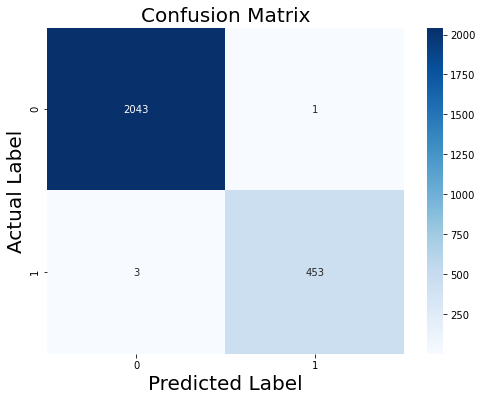

In [16]:
# Plot the confusion matrix with a seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['0', '1'], 
                                  index = ['0', '1'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label',fontsize=20)
plt.ylabel('Actual Label',fontsize=20)
plt.title('Confusion Matrix',fontsize=20)
plt.show()

In [17]:
# We will get the coefficients to see which parameter defaulting is most dependent on
features = X.columns
coefficients = logreg.coef_[0]
coef = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
0,credit_lines_outstanding,90.453718
2,total_debt_outstanding,83.035077
1,loan_amt_outstanding,10.439247
5,fico_score,-27.964226
3,income,-59.739474
4,years_employed,-67.203507


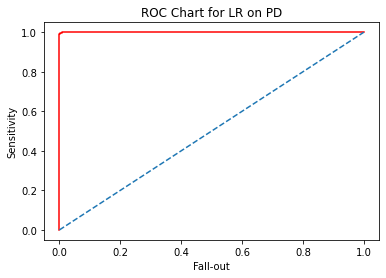

In [18]:
# Plot ROC Curve
y_pred1 = logreg.predict_proba(X_test)[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, y_pred1)
plt.plot(fallout, sensitivity, color = 'r')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.title("ROC Chart for LR on PD")
plt.show()

In [19]:
# Compute ROC AUC
ROC_AUC = roc_auc_score(y_test, y_pred1)
print('ROC AUC : {:.5f}'.format(ROC_AUC))

ROC AUC : 0.99997


ROC AUC is a single number summary of classifier performance. The higher the value, the better the classifier.

ROC AUC of our model is extremely close to 1. So, we can conclude that our classifier does a good job in predicting whether a loanee will default.

In [20]:
# Now we will find the expected loss for each loan in our database
# Firstly, we will scale our data as before
Loans_Scaled = pd.DataFrame(scaler.transform(Loans.drop(['customer_id','default'],axis=1)), columns=[cols])

# Now we predict the probability of defaulting for each loan based on our model before
Prob_Default = logreg.predict_proba(Loans_Scaled)
#print(Prob_Default[:,1])
#np.sum(Prob_Default)  # Check to see all row probabilities add to 1

# We are given a recovery rate of 10% in the task
recovery_rate = 0.1
loss_rate = 1-recovery_rate

# Now we find the expected loss for each loan
Loans['Expected_Loss'] = round(loss_rate * Loans['loan_amt_outstanding'] * Prob_Default[:,1],5)
display(Loans)

# We can also find the total expected loss across all loans
print('The total expected loss across all loans is:', round(np.sum(Loans['Expected_Loss'], axis=0),2))

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,Expected_Loss
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,0.00000
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,1763.03585
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,0.00000
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,0.00000
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,0.00000
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,0.00000
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,0.00000
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,0.00000
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,0.00000


The total expected loss across all loans is: 7426553.99


In [21]:
# Now we will come up with a function to find the expected loss of a loan
def expected_loss(model, scaler, properties, recovery_rate):
    scaled = scaler.transform([properties])
    prob_default = model.predict_proba(scaled)[:,1][0]
    loss_rate = 1-recovery_rate
    expected_loss = properties[1]*loss_rate*prob_default
    print('The expected loss of this loan is:', round(expected_loss,5))
    return

In [22]:
import warnings
warnings.filterwarnings("ignore")
properties = [5,1958.928726,8228.752520,26648.43525,2,572]
expected_loss(logreg, scaler, properties, 0.1)

The expected loss of this loan is: 1763.03585
